# Import librairies

In [72]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, SimpleRNN, RepeatVector, TimeDistributed, Flatten
from keras import regularizers
from keras.layers import Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import chart_studio.plotly as py
import plotly.graph_objects as go  # ou plotly.graph_objs, dependendo da versão
from plotly.offline import init_notebook_mode, iplot

# Basic packages
import datetime # manipulating date formats
import seaborn as sns # for prettier plots


# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow.random import set_seed
from numpy.random import seed
set_seed(1)
seed(1)

# Pré-processamento dos dados

* Carregando os dados
* Padronizando os dados
* Dividindo em treino, teste e validação

In [73]:
data = pd.read_csv('df_rio_interpolado.csv')

In [74]:
temp = data.filter(["TEMP"])
temp_values = temp.values

In [75]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(temp_values)

In [ ]:
scaled_data = temp_values

In [76]:
scaled_data.shape

(564, 1)

In [77]:
scaled_data[:5]

array([[0.77111717],
       [0.79291553],
       [0.58673933],
       [0.65849228],
       [0.28882834]])

## Train test split

In [79]:
# Definindo a proporção para treino, validação e teste
train_size = 0.7
valid_size = 0.15
test_size = 0.15

In [80]:
# Total de dados
total_data_len = len(scaled_data)
train_data_len = int(np.floor(total_data_len * train_size))
valid_data_len = int(np.floor(total_data_len * valid_size))
print(total_data_len)
print(train_data_len)
print(valid_data_len)


564
394
84


In [81]:
# Criando conjuntos de treinamento
train_data = scaled_data[0:train_data_len, :]
X_train, Y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    Y_train.append(train_data[i, 0])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(Y_train))
print(len(train_data))

334
334
394


In [82]:
# Criando o conjunto de validação
valid_data = scaled_data[train_data_len:train_data_len + valid_data_len, :]
X_valid, Y_valid = [], []

for i in range(60, len(valid_data)):
    X_valid.append(valid_data[i-60:i, 0])
    Y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(Y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
Y_valid = np.array(Y_valid)

print(len(X_valid))
print(len(Y_valid))
print(len(valid_data))

24
24
84


In [83]:
# Ajustando o conjunto de teste para garantir que o tamanho de X_test e Y_test sejam iguais
test_data = scaled_data[train_data_len + valid_data_len - 60:, :]  # Substitua a linha anterior
Y_test = temp_values[train_data_len + valid_data_len:, :]  # Permanece o mesmo

X_test = []
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(len(X_test))  # Agora deve corresponder ao tamanho de Y_test
print(len(Y_test))
print(len(test_data))

86
86
146


In [84]:
print(f'X_train length: {len(X_train)}')
print(f'Y_train length: {len(Y_train)}')
print(f'X_valid length: {len(X_valid)}')
print(f'y_valid length: {len(y_valid)}')
print(f'X_test length: {len(X_test)}')
print(f'Y_test length: {len(Y_test)}')

X_train length: 334
Y_train length: 334
X_valid length: 24
y_valid length: 24
X_test length: 86
Y_test length: 86


# MLP for Time Series Forecasting

* First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
* The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
* Input shape **[samples, timesteps]**.

In [85]:
epochs = 10
batch = 32
lr = 0.001
adam = optimizers.Adam(lr)

In [86]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(32))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mean_squared_error', optimizer=adam)
model_mlp.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
mlp_history = model_mlp.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 1s - 125ms/step - loss: 0.1850 - val_loss: 0.0322
Epoch 2/10
11/11 - 0s - 8ms/step - loss: 0.0314 - val_loss: 0.0410
Epoch 3/10
11/11 - 0s - 8ms/step - loss: 0.0228 - val_loss: 0.0199
Epoch 4/10
11/11 - 0s - 13ms/step - loss: 0.0151 - val_loss: 0.0218
Epoch 5/10
11/11 - 0s - 7ms/step - loss: 0.0139 - val_loss: 0.0211
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 0.0126 - val_loss: 0.0176
Epoch 7/10
11/11 - 0s - 8ms/step - loss: 0.0123 - val_loss: 0.0170
Epoch 8/10
11/11 - 0s - 13ms/step - loss: 0.0120 - val_loss: 0.0167
Epoch 9/10
11/11 - 0s - 10ms/step - loss: 0.0116 - val_loss: 0.0161
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 0.0113 - val_loss: 0.0156


In [88]:
model_reg = Sequential()
model_reg.add(Dense(64, activation='relu', input_dim=X_train.shape[1], 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(32, activation='relu', 
                     kernel_regularizer=regularizers.l2(0.01)))  # Regularização L2
model_reg.add(Dense(1))  # Saída
model_reg.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_reg.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
mlp_reg_history = model_reg.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 151ms/step - loss: 1.1041 - val_loss: 0.9948
Epoch 2/10
11/11 - 0s - 8ms/step - loss: 0.9677 - val_loss: 0.9203
Epoch 3/10
11/11 - 0s - 8ms/step - loss: 0.8858 - val_loss: 0.8352
Epoch 4/10
11/11 - 0s - 8ms/step - loss: 0.8078 - val_loss: 0.7653
Epoch 5/10
11/11 - 0s - 15ms/step - loss: 0.7367 - val_loss: 0.6951
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 0.6706 - val_loss: 0.6339
Epoch 7/10
11/11 - 0s - 7ms/step - loss: 0.6102 - val_loss: 0.5764
Epoch 8/10
11/11 - 0s - 7ms/step - loss: 0.5549 - val_loss: 0.5242
Epoch 9/10
11/11 - 0s - 9ms/step - loss: 0.5046 - val_loss: 0.4768
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 0.4587 - val_loss: 0.4333


In [90]:
model_dropout = Sequential()
model_dropout.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(32, activation='relu'))
model_dropout.add(Dropout(0.5))  # 50% de dropout
model_dropout.add(Dense(1))  # Saída
model_dropout.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
model_dropout.summary()



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,017 (23.50 KB)

 Trainable params: 6,017 (23.50 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:
mlp_drop_history = model_dropout.fit(X_train, Y_train, 
                            validation_data=(X_valid, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/10
11/11 - 2s - 153ms/step - loss: 0.9210 - val_loss: 0.1006
Epoch 2/10
11/11 - 0s - 18ms/step - loss: 0.3586 - val_loss: 0.0709
Epoch 3/10
11/11 - 0s - 7ms/step - loss: 0.2050 - val_loss: 0.0741
Epoch 4/10
11/11 - 0s - 15ms/step - loss: 0.1679 - val_loss: 0.0585
Epoch 5/10
11/11 - 0s - 7ms/step - loss: 0.1405 - val_loss: 0.0493
Epoch 6/10
11/11 - 0s - 7ms/step - loss: 0.0967 - val_loss: 0.0438
Epoch 7/10
11/11 - 0s - 8ms/step - loss: 0.0929 - val_loss: 0.0408
Epoch 8/10
11/11 - 0s - 7ms/step - loss: 0.0807 - val_loss: 0.0404
Epoch 9/10
11/11 - 0s - 7ms/step - loss: 0.0770 - val_loss: 0.0352
Epoch 10/10
11/11 - 0s - 7ms/step - loss: 0.0711 - val_loss: 0.0300


## Comparando os 3 modelos

In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Função para calcular e exibir as métricas de cada modelo
def evaluate_model(model, X_test, Y_test, model_name="Modelo"):
    # Realiza as previsões no conjunto de teste
    Y_pred = model.predict(X_test)
    
    # Calcula as métricas
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    
    # Exibe os resultados
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    
    return mae, mse, rmse

# Avaliação de cada modelo no conjunto de teste
mae_standard, mse_standard, rmse_standard = evaluate_model(model_mlp, X_test, Y_test, "Modelo Padrão")
mae_reg, mse_reg, rmse_reg = evaluate_model(model_reg, X_test, Y_test, "Modelo com Regularização")
mae_dropout, mse_dropout, rmse_dropout = evaluate_model(model_dropout, X_test, Y_test, "Modelo com Dropout")

# Comparação dos resultados (opcional)
print("\nComparação de resultados:")
print(f"Modelo Padrão - MAE: {mae_standard:.4f}, RMSE: {rmse_standard:.4f}")
print(f"Modelo com Regularização - MAE: {mae_reg:.4f}, RMSE: {rmse_reg:.4f}")
print(f"Modelo com Dropout - MAE: {mae_dropout:.4f}, RMSE: {rmse_dropout:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Modelo Padrão:
MAE: 24.5609
MSE: 608.2161
RMSE: 24.6620
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

Modelo com Regularização:
MAE: 24.5588
MSE: 608.1653
RMSE: 24.6610
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 

Modelo com Dropout:
MAE: 24.7138
MSE: 616.1061
RMSE: 24.8215

Comparação de resultados:
Modelo Padrão - MAE: 24.5609, RMSE: 24.6620
Modelo com Regularização - MAE: 24.5588, RMSE: 24.6610
Modelo com Dropout - MAE: 24.7138, RMSE: 24.8215


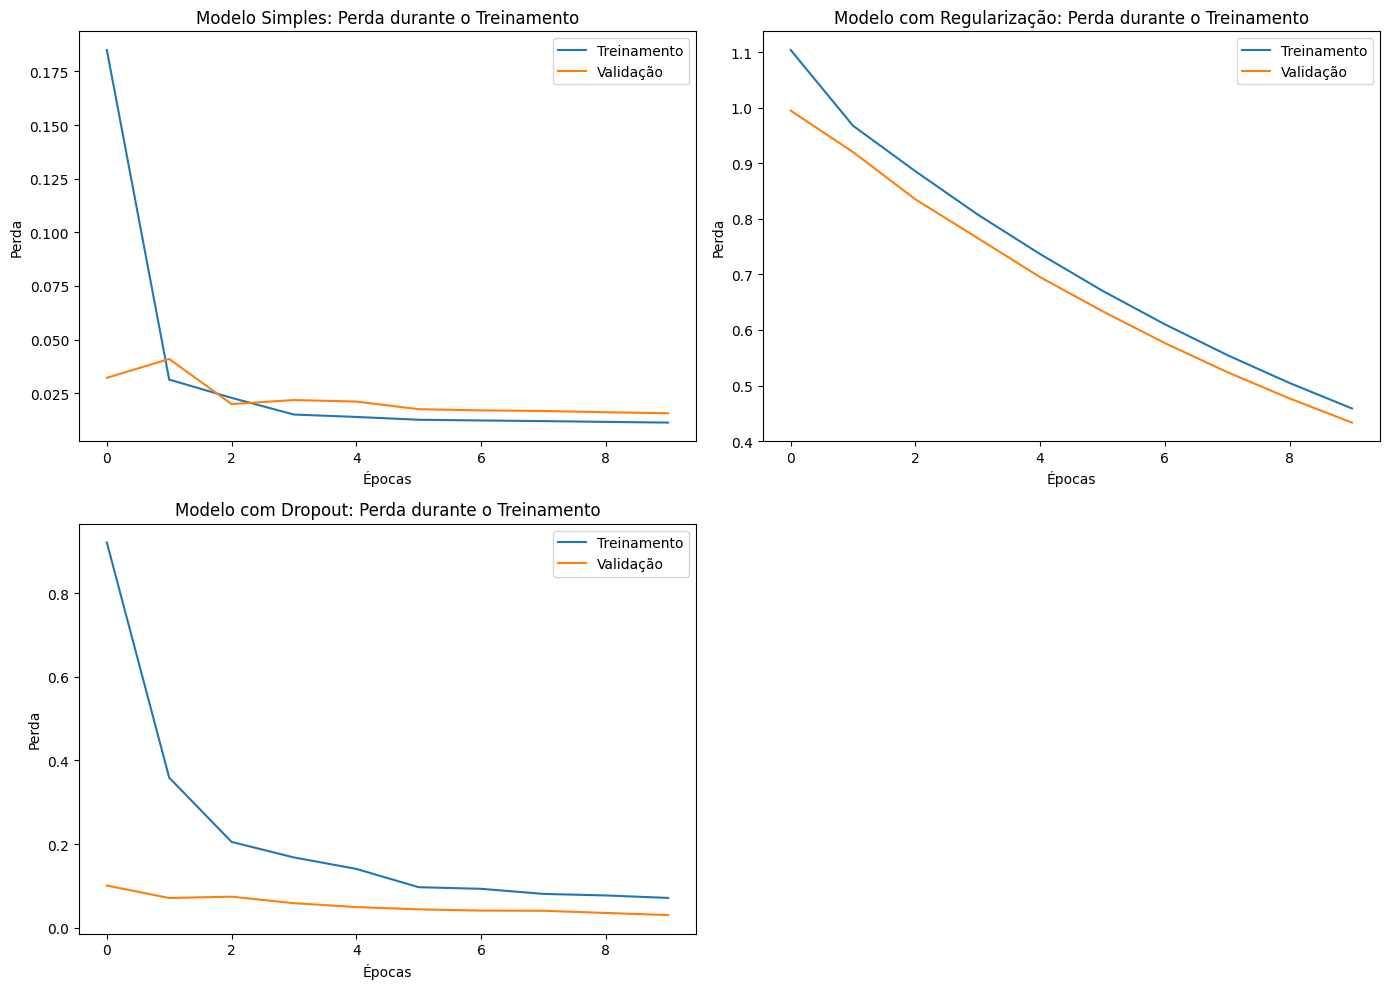

In [93]:
# Gráficos de ajuste combinado no conjunto de treinamento e validação e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(mlp_history.history['loss'], label='Treinamento')
plt.plot(mlp_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(mlp_reg_history.history['loss'], label='Treinamento')
plt.plot(mlp_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(mlp_drop_history.history['loss'], label='Treinamento')
plt.plot(mlp_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# # Modelo com Regularização e Dropout
# plt.subplot(2, 2, 4)
# plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
# plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
# plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
# plt.xlabel('Épocas')
# plt.ylabel('Perda')
# plt.legend()

plt.tight_layout()
plt.show()

In [113]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_mlp, "MLP Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_reg, "MLP com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, y_pred_drop, "MLP com Dropout")

NameError: name 'y_pred_mlp' is not defined

# CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

#### Data preprocess
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [95]:
#Hiperparametros
epochs = 20
batch = 32
lr = 0.001
#adam = optimizers.Adam(lr)


In [96]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Test set shape', X_test_series.shape)

Train set shape (334, 60, 1)
Validation set shape (24, 60, 1)
Test set shape (86, 60, 1)


## Aplicando Modelo CNN

In [97]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
cnn_history = model_cnn.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/20
11/11 - 1s - 121ms/step - loss: 0.0374 - val_loss: 0.0089
Epoch 2/20
11/11 - 0s - 8ms/step - loss: 0.0166 - val_loss: 0.0094
Epoch 3/20
11/11 - 0s - 10ms/step - loss: 0.0147 - val_loss: 0.0102
Epoch 4/20
11/11 - 0s - 8ms/step - loss: 0.0134 - val_loss: 0.0079
Epoch 5/20
11/11 - 0s - 8ms/step - loss: 0.0128 - val_loss: 0.0081
Epoch 6/20
11/11 - 0s - 8ms/step - loss: 0.0122 - val_loss: 0.0074
Epoch 7/20
11/11 - 0s - 8ms/step - loss: 0.0118 - val_loss: 0.0073
Epoch 8/20
11/11 - 0s - 8ms/step - loss: 0.0114 - val_loss: 0.0071
Epoch 9/20
11/11 - 0s - 8ms/step - loss: 0.0110 - val_loss: 0.0071
Epoch 10/20
11/11 - 0s - 8ms/step - loss: 0.0106 - val_loss: 0.0071
Epoch 11/20
11/11 - 0s - 8ms/step - loss: 0.0103 - val_loss: 0.0072
Epoch 12/20
11/11 - 0s - 8ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 0.0098 - val_loss: 0.0074
Epoch 14/20
11/11 - 0s - 8ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 15/20
11/11 - 0s - 8ms/step - loss: 0.0092 - val

## Aplicando Regularização

In [99]:
model_cnn_reg = Sequential()
model_cnn_reg.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01),  # Regularização L2
                         input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_reg.add(MaxPooling1D(pool_size=2))
model_cnn_reg.add(Flatten())
model_cnn_reg.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_reg.add(Dense(1))
model_cnn_reg.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_reg.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [100]:
cnn_reg_history = model_cnn_reg.fit(X_train_series, Y_train, 
                            validation_data=(X_valid_series, Y_valid), 
                            epochs=epochs, 
                            verbose=2)

Epoch 1/20
11/11 - 1s - 130ms/step - loss: 0.8898 - val_loss: 0.6562
Epoch 2/20
11/11 - 0s - 8ms/step - loss: 0.5375 - val_loss: 0.4000
Epoch 3/20
11/11 - 0s - 9ms/step - loss: 0.3330 - val_loss: 0.2521
Epoch 4/20
11/11 - 0s - 9ms/step - loss: 0.2152 - val_loss: 0.1679
Epoch 5/20
11/11 - 0s - 9ms/step - loss: 0.1498 - val_loss: 0.1216
Epoch 6/20
11/11 - 0s - 8ms/step - loss: 0.1128 - val_loss: 0.0940
Epoch 7/20
11/11 - 0s - 10ms/step - loss: 0.0903 - val_loss: 0.0764
Epoch 8/20
11/11 - 0s - 9ms/step - loss: 0.0753 - val_loss: 0.0639
Epoch 9/20
11/11 - 0s - 8ms/step - loss: 0.0642 - val_loss: 0.0548
Epoch 10/20
11/11 - 0s - 8ms/step - loss: 0.0560 - val_loss: 0.0474
Epoch 11/20
11/11 - 0s - 8ms/step - loss: 0.0494 - val_loss: 0.0420
Epoch 12/20
11/11 - 0s - 8ms/step - loss: 0.0443 - val_loss: 0.0377
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 0.0402 - val_loss: 0.0341
Epoch 14/20
11/11 - 0s - 8ms/step - loss: 0.0370 - val_loss: 0.0313
Epoch 15/20
11/11 - 0s - 8ms/step - loss: 0.0344 - val

## Aplicando Dropout

In [101]:
model_cnn_drop = Sequential()
model_cnn_drop.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_drop.add(MaxPooling1D(pool_size=2))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada de pooling
model_cnn_drop.add(Flatten())
model_cnn_drop.add(Dense(50, activation='relu'))
model_cnn_drop.add(Dropout(0.5))  # Dropout após camada densa
model_cnn_drop.add(Dense(1))
model_cnn_drop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_drop.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
cnn_drop_history = model_cnn_drop.fit(X_train_series, Y_train, 
                                       validation_data=(X_valid_series, Y_valid), 
                                       epochs=epochs, 
                                       verbose=2)


Epoch 1/20
11/11 - 2s - 146ms/step - loss: 0.1234 - val_loss: 0.0341
Epoch 2/20
11/11 - 0s - 9ms/step - loss: 0.0580 - val_loss: 0.0160
Epoch 3/20
11/11 - 0s - 9ms/step - loss: 0.0360 - val_loss: 0.0119
Epoch 4/20
11/11 - 0s - 9ms/step - loss: 0.0359 - val_loss: 0.0100
Epoch 5/20
11/11 - 0s - 9ms/step - loss: 0.0299 - val_loss: 0.0100
Epoch 6/20
11/11 - 0s - 9ms/step - loss: 0.0265 - val_loss: 0.0101
Epoch 7/20
11/11 - 0s - 8ms/step - loss: 0.0286 - val_loss: 0.0094
Epoch 8/20
11/11 - 0s - 8ms/step - loss: 0.0275 - val_loss: 0.0090
Epoch 9/20
11/11 - 0s - 8ms/step - loss: 0.0285 - val_loss: 0.0091
Epoch 10/20
11/11 - 0s - 8ms/step - loss: 0.0315 - val_loss: 0.0103
Epoch 11/20
11/11 - 0s - 8ms/step - loss: 0.0290 - val_loss: 0.0095
Epoch 12/20
11/11 - 0s - 8ms/step - loss: 0.0257 - val_loss: 0.0095
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 0.0242 - val_loss: 0.0092
Epoch 14/20
11/11 - 0s - 8ms/step - loss: 0.0267 - val_loss: 0.0095
Epoch 15/20
11/11 - 0s - 8ms/step - loss: 0.0260 - val_

## Aplicando Regularização e Dropout combinados

In [103]:
model_cnn_regdrop = Sequential()
model_cnn_regdrop.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                             kernel_regularizer=regularizers.l2(0.01),
                             input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn_regdrop.add(MaxPooling1D(pool_size=2))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Flatten())
model_cnn_regdrop.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_cnn_regdrop.add(Dropout(0.5))
model_cnn_regdrop.add(Dense(1))
model_cnn_regdrop.compile(loss='mse', optimizer=optimizers.Adam())
model_cnn_regdrop.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 59, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1856)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 50)             │        92,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,093 (363.64 KB)

 Trainable params: 93,093 (363.64 KB)

 Non-trainable params: 0 (0.00 B)

In [104]:
cnn_regdrop_history = model_cnn_regdrop.fit(X_train_series, Y_train, 
                                             validation_data=(X_valid_series, Y_valid), 
                                             epochs=epochs, 
                                             verbose=2)


Epoch 1/20
11/11 - 2s - 149ms/step - loss: 0.9647 - val_loss: 0.7178
Epoch 2/20
11/11 - 0s - 11ms/step - loss: 0.6147 - val_loss: 0.4462
Epoch 3/20
11/11 - 0s - 10ms/step - loss: 0.4049 - val_loss: 0.2967
Epoch 4/20
11/11 - 0s - 9ms/step - loss: 0.2775 - val_loss: 0.2074
Epoch 5/20
11/11 - 0s - 8ms/step - loss: 0.2103 - val_loss: 0.1591
Epoch 6/20
11/11 - 0s - 8ms/step - loss: 0.1677 - val_loss: 0.1290
Epoch 7/20
11/11 - 0s - 8ms/step - loss: 0.1383 - val_loss: 0.1088
Epoch 8/20
11/11 - 0s - 8ms/step - loss: 0.1253 - val_loss: 0.0933
Epoch 9/20
11/11 - 0s - 8ms/step - loss: 0.1079 - val_loss: 0.0834
Epoch 10/20
11/11 - 0s - 8ms/step - loss: 0.0972 - val_loss: 0.0716
Epoch 11/20
11/11 - 0s - 8ms/step - loss: 0.0865 - val_loss: 0.0639
Epoch 12/20
11/11 - 0s - 9ms/step - loss: 0.0786 - val_loss: 0.0581
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 0.0734 - val_loss: 0.0542
Epoch 14/20
11/11 - 0s - 9ms/step - loss: 0.0687 - val_loss: 0.0489
Epoch 15/20
11/11 - 0s - 8ms/step - loss: 0.0634 - va

## Preivsao dos Modelos

In [105]:
# Previsões
predictions_simple = model_cnn.predict(X_test)
predictions_reg = model_cnn_reg.predict(X_test)
predictions_drop = model_cnn_drop.predict(X_test)
predictions_regdrop = model_cnn_regdrop.predict(X_test)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [106]:
# Função para calcular MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Função para calcular MSE
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Função para calcular RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Cálculo das métricas para cada modelo
metrics = {
    "Modelo Simples": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_simple),
        "MSE": mean_squared_error(Y_test, predictions_simple),
        "RMSE": root_mean_squared_error(Y_test, predictions_simple)
    },
    "Modelo com Regularização": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_reg),
        "MSE": mean_squared_error(Y_test, predictions_reg),
        "RMSE": root_mean_squared_error(Y_test, predictions_reg)
    },
    "Modelo com Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_drop),
        "MSE": mean_squared_error(Y_test, predictions_drop),
        "RMSE": root_mean_squared_error(Y_test, predictions_drop)
    },
    "Modelo com Regularização e Dropout": {
        "MAPE": mean_absolute_percentage_error(Y_test, predictions_regdrop),
        "MSE": mean_squared_error(Y_test, predictions_regdrop),
        "RMSE": root_mean_squared_error(Y_test, predictions_regdrop)
    }
}

# Exibir as métricas
for model, values in metrics.items():
    print(f"{model}: MAPE={values['MAPE']:.2f}%, MSE={values['MSE']:.4f}, RMSE={values['RMSE']:.4f}")


Modelo Simples: MAPE=98.04%, MSE=608.6752, RMSE=24.6713
Modelo com Regularização: MAPE=98.11%, MSE=609.5717, RMSE=24.6895
Modelo com Dropout: MAPE=98.11%, MSE=609.7619, RMSE=24.6934
Modelo com Regularização e Dropout: MAPE=98.06%, MSE=608.9652, RMSE=24.6772


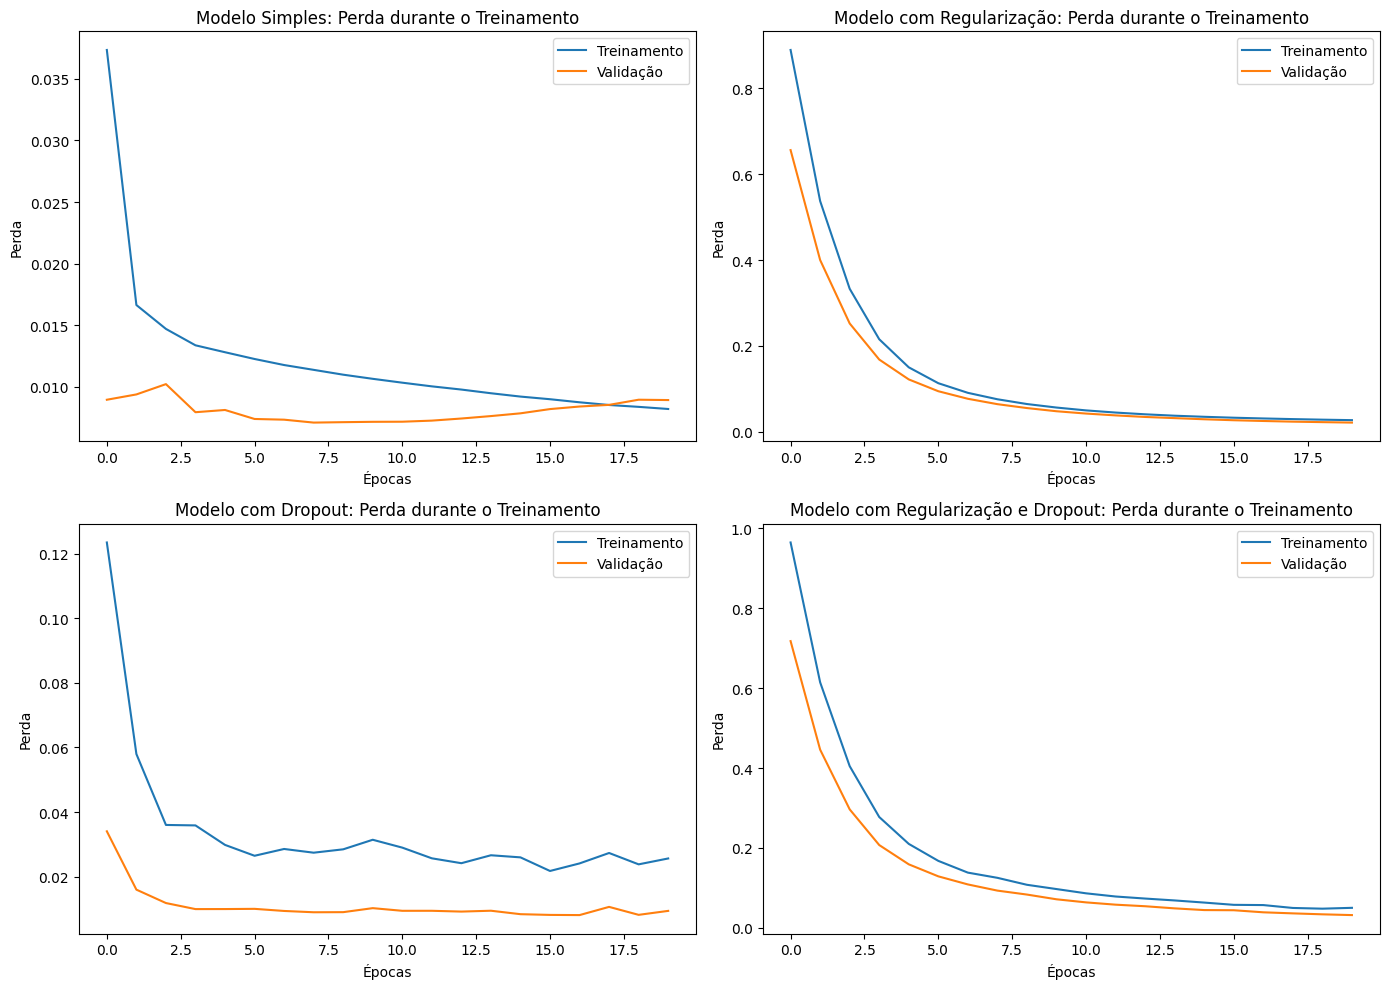

In [107]:
# Gráficos de perda durante o treinamento
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(cnn_history.history['loss'], label='Treinamento')
plt.plot(cnn_history.history['val_loss'], label='Validação')
plt.title('Modelo Simples: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(cnn_reg_history.history['loss'], label='Treinamento')
plt.plot(cnn_reg_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(cnn_drop_history.history['loss'], label='Treinamento')
plt.plot(cnn_drop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(cnn_regdrop_history.history['loss'], label='Treinamento')
plt.plot(cnn_regdrop_history.history['val_loss'], label='Validação')
plt.title('Modelo com Regularização e Dropout: Perda durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


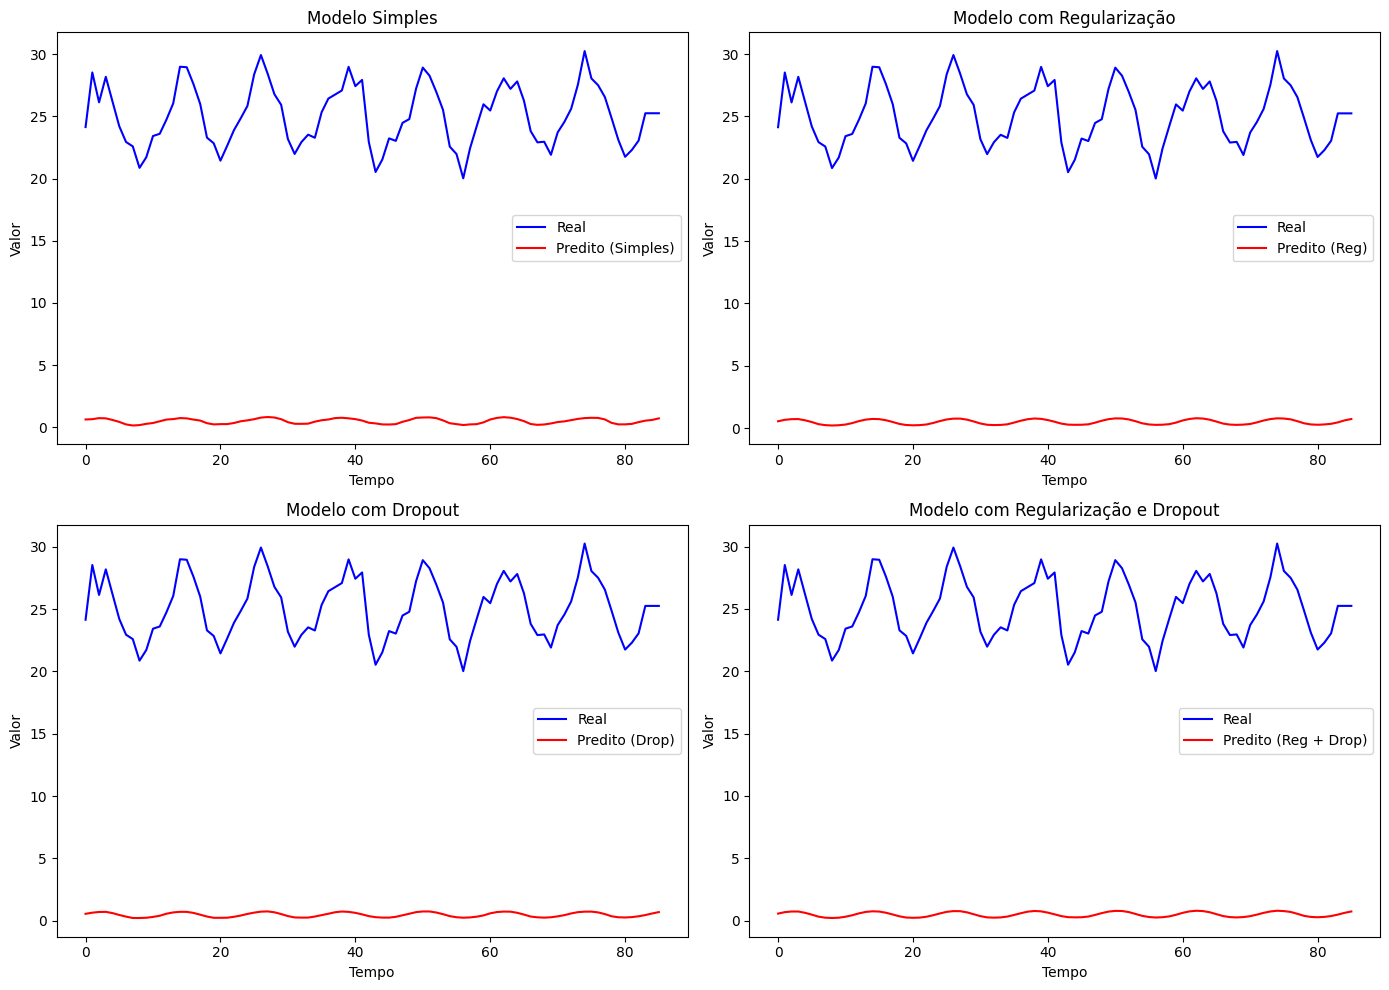

In [108]:
# Gráficos de predição
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_simple, label='Predito (Simples)', color='red')
plt.title('Modelo Simples')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_reg, label='Predito (Reg)', color='red')
plt.title('Modelo com Regularização')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_drop, label='Predito (Drop)', color='red')
plt.title('Modelo com Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_test, label='Real', color='blue')
plt.plot(predictions_regdrop, label='Predito (Reg + Drop)', color='red')
plt.title('Modelo com Regularização e Dropout')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


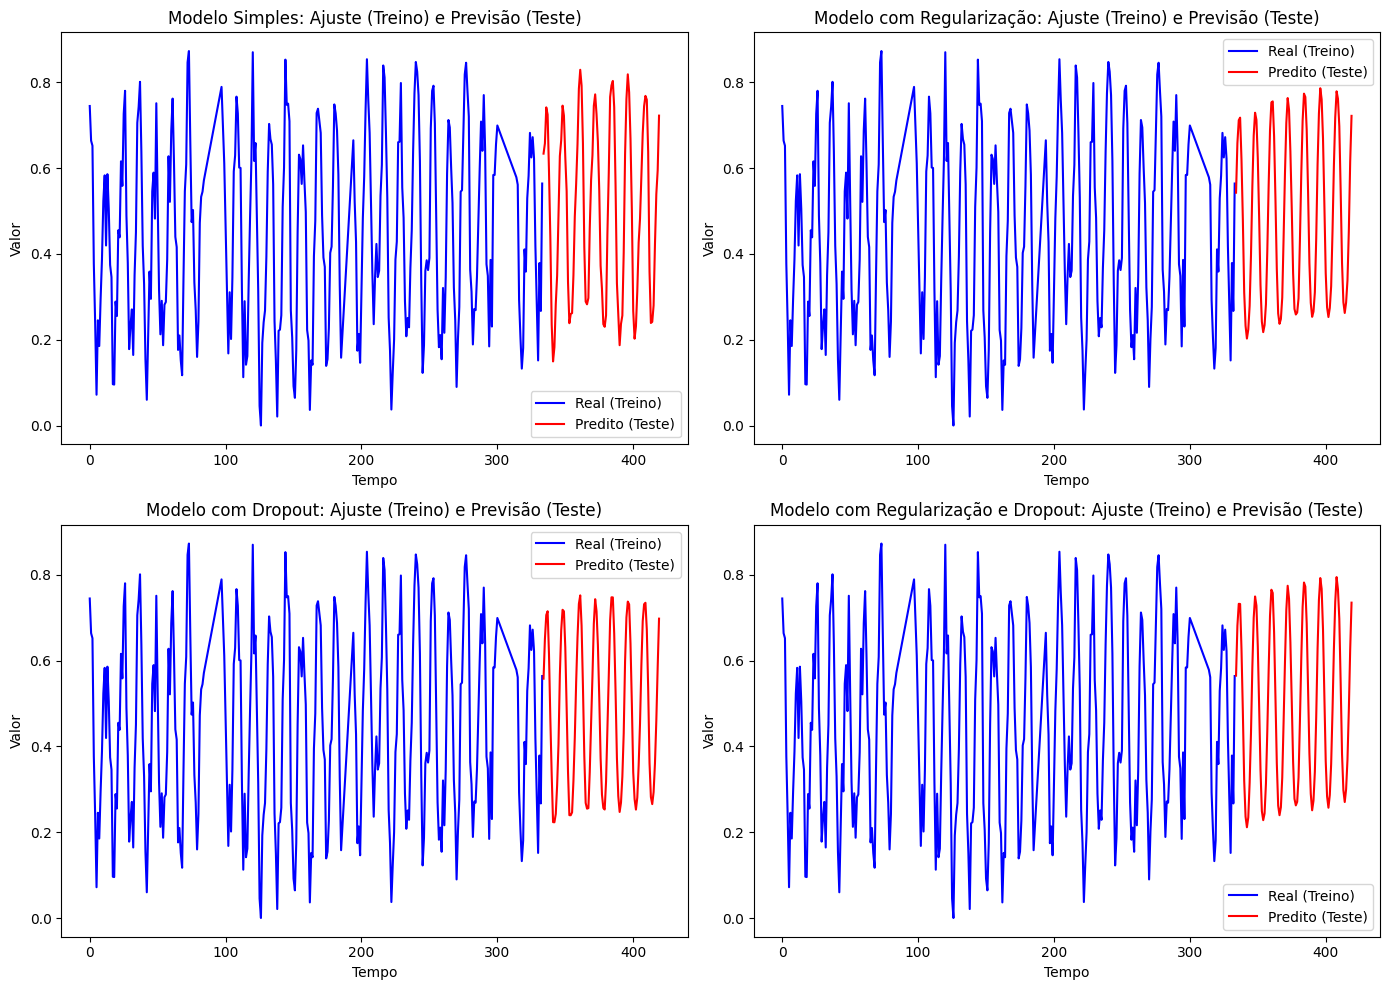

In [109]:
# Gráficos de ajuste no conjunto de treinamento e previsão no conjunto de teste
plt.figure(figsize=(14, 10))

# Modelo Simples
plt.subplot(2, 2, 1)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_simple)), predictions_simple, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo Simples: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização
plt.subplot(2, 2, 2)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_reg)), predictions_reg, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Dropout
plt.subplot(2, 2, 3)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_drop)), predictions_drop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

# Modelo com Regularização e Dropout
plt.subplot(2, 2, 4)
plt.plot(Y_train, label='Real (Treino)', color='blue')  # Ajuste no conjunto de treino
plt.plot(np.arange(len(Y_train), len(Y_train) + len(predictions_regdrop)), predictions_regdrop, label='Predito (Teste)', color='red')  # Previsão no conjunto de teste
plt.title('Modelo com Regularização e Dropout: Ajuste (Treino) e Previsão (Teste)')
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()

plt.tight_layout()
plt.show()


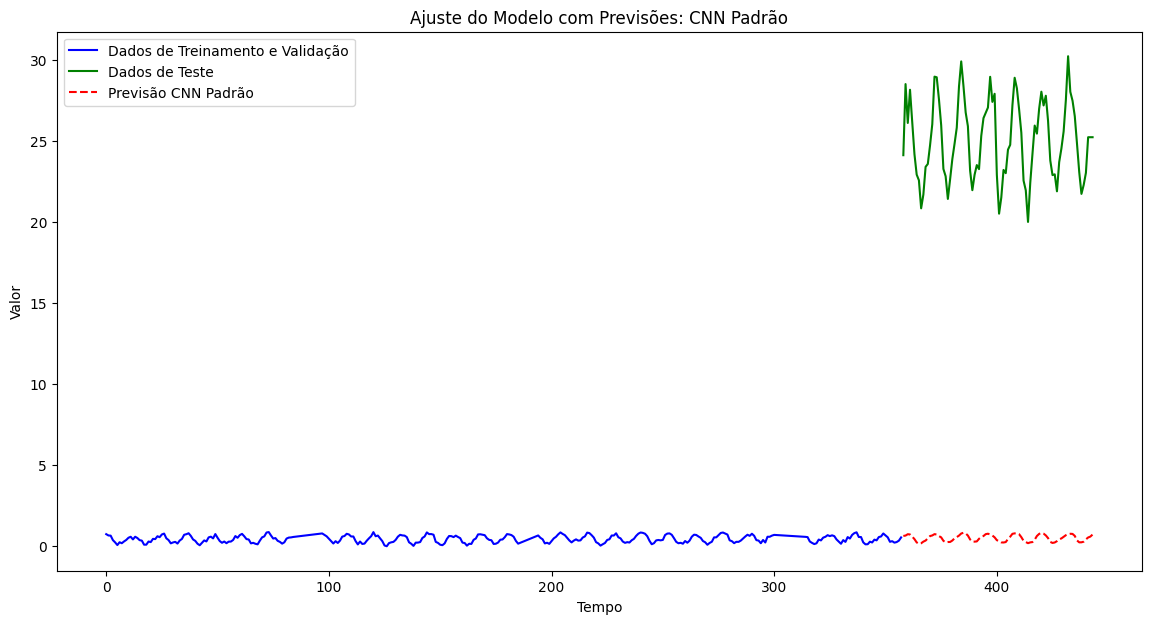

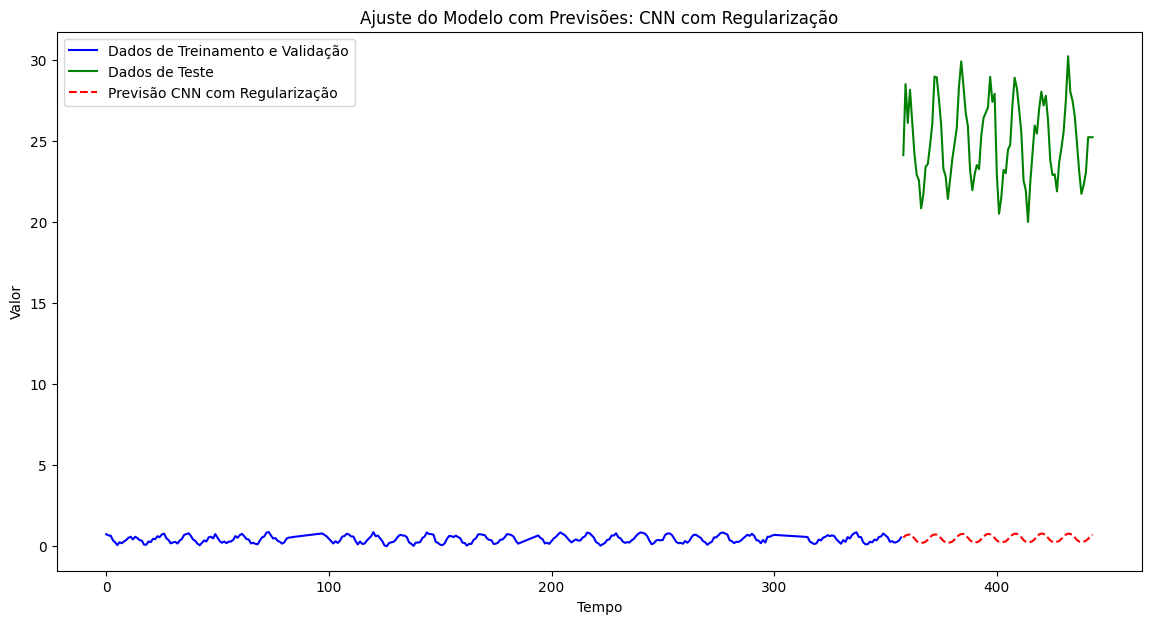

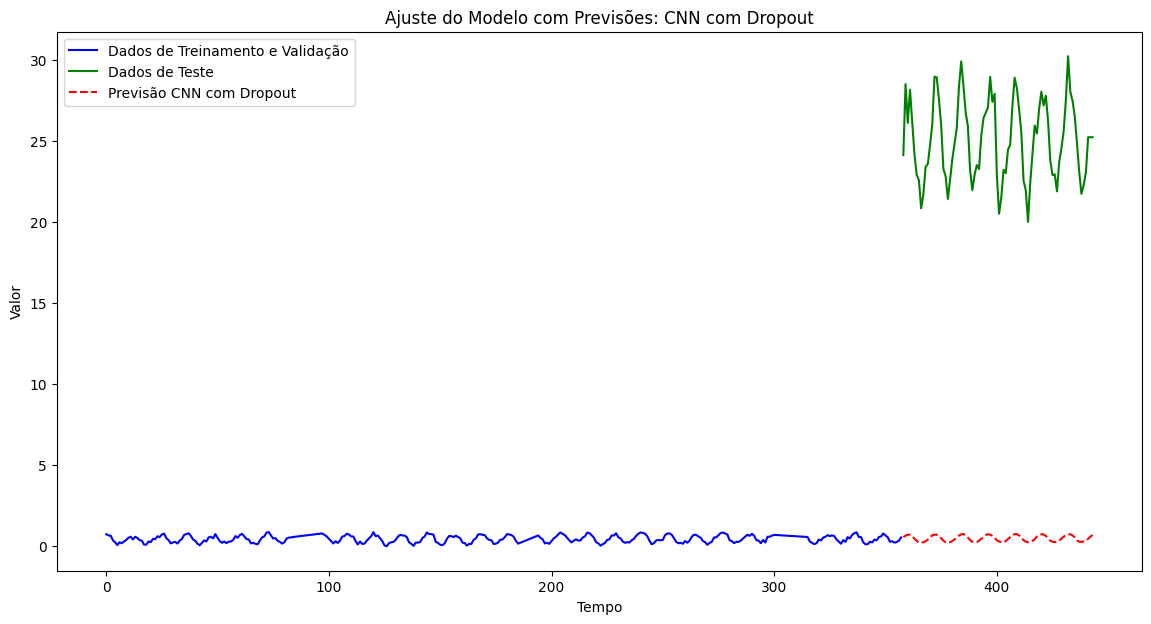

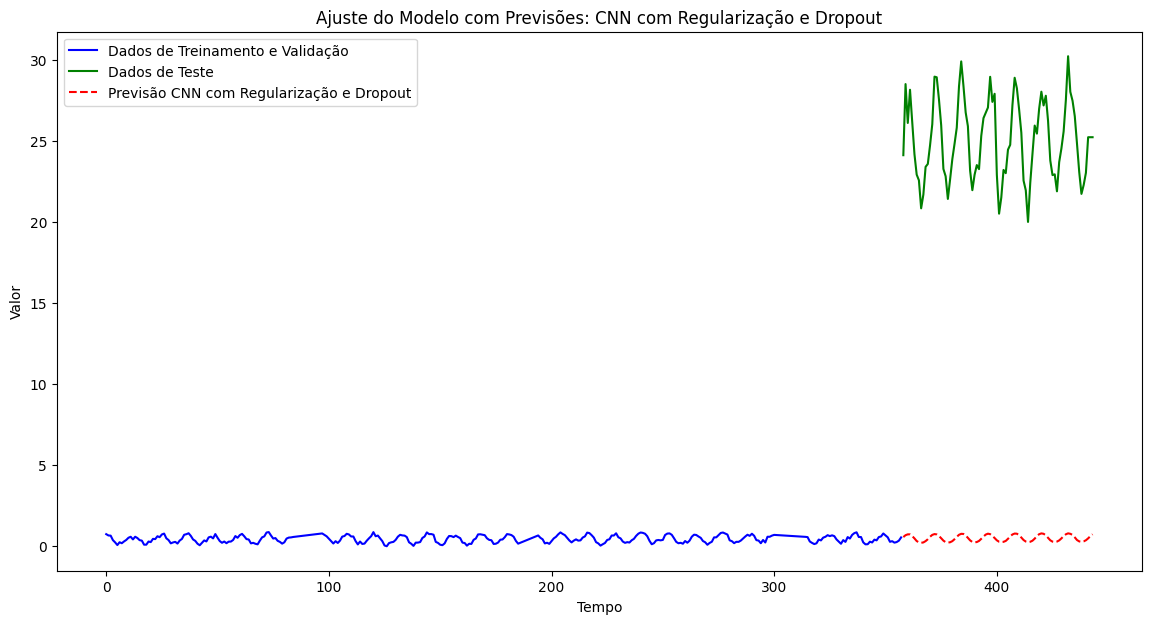

In [110]:
# Combine os dados de treino e validação em uma série para comparação visual com o conjunto de teste e previsões.
train_valid_data = np.concatenate([Y_train, Y_valid])  # Combina Y_train e Y_valid em uma série contínua

def plot_fit_with_predictions(train_valid_data, y_test, y_pred, model_name):
    plt.figure(figsize=(14, 7))
    
    # Plot dos dados de treino e validação
    plt.plot(range(len(train_valid_data)), train_valid_data, label="Dados de Treinamento e Validação", color="blue")
    
    # Plot dos dados de teste
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_test, label="Dados de Teste", color="green")
    
    # Plot das previsões
    plt.plot(range(len(train_valid_data), len(train_valid_data) + len(y_test)), y_pred, label=f"Previsão {model_name}", color="red", linestyle="--")
    
    plt.title(f"Ajuste do Modelo com Previsões: {model_name}")
    plt.xlabel("Tempo")
    plt.ylabel("Valor")
    plt.legend()
    plt.show()

# Plot do ajuste e previsão para cada modelo
plot_fit_with_predictions(train_valid_data, Y_test, predictions_simple, "CNN Padrão")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_reg, "CNN com Regularização")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_drop, "CNN com Dropout")
plot_fit_with_predictions(train_valid_data, Y_test, predictions_regdrop, "CNN com Regularização e Dropout")

# LSTM for Time Series Forecasting

* Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
* Input shape **[samples, timesteps, features]**.

In [65]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='tanh', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=optimizers.Adam())
model_lstm.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=15, verbose=2)

Epoch 1/15
11/11 - 3s - 276ms/step - loss: 612.1807 - val_loss: 579.4474
Epoch 2/15
11/11 - 0s - 30ms/step - loss: 565.6359 - val_loss: 538.9734
Epoch 3/15
11/11 - 0s - 40ms/step - loss: 525.3078 - val_loss: 497.5480
Epoch 4/15
11/11 - 1s - 46ms/step - loss: 482.0794 - val_loss: 451.4311
Epoch 5/15
11/11 - 0s - 31ms/step - loss: 433.5675 - val_loss: 401.7878
Epoch 6/15
11/11 - 0s - 31ms/step - loss: 386.3129 - val_loss: 358.1352
Epoch 7/15
11/11 - 0s - 21ms/step - loss: 344.1666 - val_loss: 319.0901
Epoch 8/15
11/11 - 0s - 28ms/step - loss: 307.2392 - val_loss: 285.3972
Epoch 9/15
11/11 - 0s - 24ms/step - loss: 273.3243 - val_loss: 249.5125
Epoch 10/15
11/11 - 0s - 23ms/step - loss: 235.9312 - val_loss: 213.0459
Epoch 11/15
11/11 - 0s - 29ms/step - loss: 200.9870 - val_loss: 180.3166
Epoch 12/15
11/11 - 0s - 33ms/step - loss: 170.4737 - val_loss: 154.6104
Epoch 13/15
11/11 - 0s - 24ms/step - loss: 148.7137 - val_loss: 136.6457
Epoch 14/15
11/11 - 0s - 24ms/step - loss: 130.3198 - val_l

# CNN-LSTM for Time Series Forecasting
* Input shape **[samples, subsequences, timesteps, features]**.

#### Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

#### Data preprocess
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [67]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (334, 2, 30, 1)
Validation set shape (24, 2, 30, 1)


In [70]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=optimizers.Adam())

In [71]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/20
11/11 - 4s - 359ms/step - loss: 98.5148 - val_loss: 4.9884
Epoch 2/20
11/11 - 0s - 13ms/step - loss: 6.5289 - val_loss: 6.2736
Epoch 3/20
11/11 - 0s - 15ms/step - loss: 6.4010 - val_loss: 5.0431
Epoch 4/20
11/11 - 0s - 14ms/step - loss: 5.4654 - val_loss: 5.2121
Epoch 5/20
11/11 - 0s - 13ms/step - loss: 4.6125 - val_loss: 4.3710
Epoch 6/20
11/11 - 0s - 15ms/step - loss: 4.2339 - val_loss: 3.8592
Epoch 7/20
11/11 - 0s - 13ms/step - loss: 3.9177 - val_loss: 3.4922
Epoch 8/20
11/11 - 0s - 16ms/step - loss: 3.5111 - val_loss: 3.3184
Epoch 9/20
11/11 - 0s - 14ms/step - loss: 2.9520 - val_loss: 2.5441
Epoch 10/20
11/11 - 0s - 12ms/step - loss: 2.2775 - val_loss: 1.6939
Epoch 11/20
11/11 - 0s - 14ms/step - loss: 1.8716 - val_loss: 1.3770
Epoch 12/20
11/11 - 0s - 14ms/step - loss: 1.7615 - val_loss: 1.2637
Epoch 13/20
11/11 - 0s - 13ms/step - loss: 1.7299 - val_loss: 1.2524
Epoch 14/20
11/11 - 0s - 14ms/step - loss: 1.7083 - val_loss: 1.2522
Epoch 15/20
11/11 - 0s - 15ms/step - loss